# Applied Programming Lab: Week 3 Submission
**by Niranjan A. Kartha (EE21B095)**

____

# Running the notebook

This notebook uses the `numpy`, `matplotlib` and `scipy` libraries which need to be installed for the cells to run without errors.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import timeit
%matplotlib inline

____

# Dataset 1

We can load the data file using `np.loadtxt`

In [2]:
d = np.loadtxt("dataset1.txt", delimiter=" ")
x = d[0:, 0]
y = d[0:, 1]

d

array([[0.00000000e+00, 1.60650023e+00],
       [2.50250250e-02, 4.03593098e+00],
       [5.00500501e-02, 6.90478380e+00],
       ...,
       [2.49499499e+01, 7.41839670e+01],
       [2.49749750e+01, 7.38712219e+01],
       [2.50000000e+01, 6.98274894e+01]])

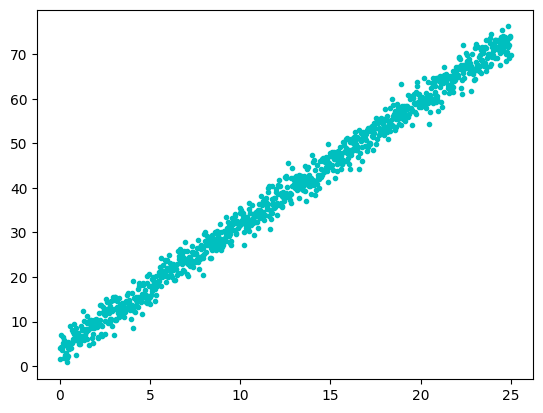

In [3]:
plt.plot(x, y, 'c.')

We fit $y(t) = p_1 t + p_2$ to the data in two ways:

1. Using `numpy.linalg.lstsq`
2. Using `scipy.optimize.curve_fit`

## Least squares

In [4]:
M = np.column_stack([x, np.ones(len(d))])
(p1, p2), _, _, _ = np.linalg.lstsq(M, y, rcond=None)

print("we estimate the line to be:")
print(f"{p1} x + {p2}")

we estimate the line to be:
2.791124245414918 x + 3.848800101430743


We can measure the mean squared error to get an idea of how good our fit is:

In [5]:
mse = np.mean((y - (p1 * x + p2)) ** 2)
mse

3.983412380573274

We can also measure the $r^2$ score:

In [6]:
var_y = np.var(y) # find the variance
r2 = 1 - mse/var_y
r2

0.990297243336745

Then we plot it alongside the data. We use the root mean squared error for the error range of our graph.

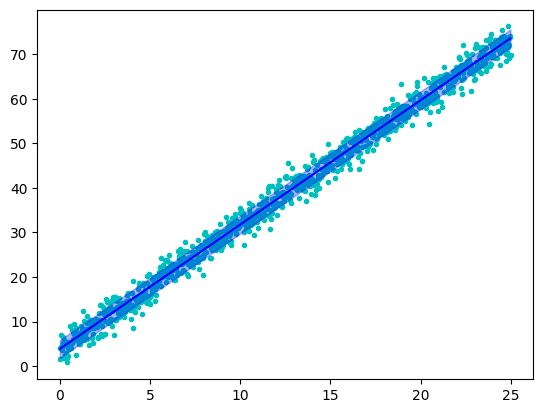

In [7]:
max_x = np.max(x)
min_x = np.min(x)
t = np.arange(min_x, max_x, (max_x - min_x) / len(x))

plt.plot(x, y, 'c.', t, p1 * t + p2, 'b')
plt.fill_between(t, p1 * t + p2 - np.sqrt(mse), p1 * t + p2 + np.sqrt(mse),
                 color='blue', alpha=0.3, zorder=2)

## Curve fitting

In [8]:
def line(t, p1, p2):
    return p1 * t + p2
(zp1, zp2), pcov = curve_fit(line, x, y)

print("we estimate the line to be:")
print(f"{zp1} x + {zp2}")

we estimate the line to be:
2.7911242448201588 x + 3.848800111263445


We can measure the mean squared error to get an idea of how good our fit is:

In [9]:
mse2 = np.mean((y - (zp1 * x + zp2)) ** 2)
mse2

3.983412380573275

We can also measure the $r^2$ score:

In [10]:
r2_2 = 1 - mse2/var_y
r2_2

0.990297243336745

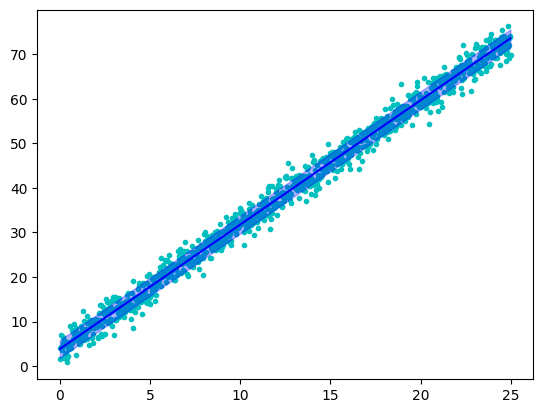

In [11]:
plt.plot(x, y, 'c.', t, zp1 * t + zp2, 'blue')
plt.fill_between(t, zp1 * t + zp2 - np.sqrt(mse2),
                 zp1 * t + zp2 + np.sqrt(mse2), color='blue', alpha=0.3,
                 zorder=2)

## Comparison

We can compare the methods for both the accuracy of the fit and the time it takes to generate the fit.

### Accuracy

In [12]:
print("measurement".ljust(20) + "least squares".ljust(20) + "curve fitting")
print("mse".ljust(20) + f"{mse:<20}{mse2}")
print("r^2".ljust(20) + f"{r2:<20}{r2_2}")

measurement         least squares       curve fitting
mse                 3.983412380573274   3.983412380573275
r^2                 0.990297243336745   0.990297243336745


As we can see, both methods give essentially the same fit for the data. This is because curve fitting also tries to minimize the mean squared error of the fit, just like least squares.

### Timing

In [13]:
%timeit np.linalg.lstsq(M, y, rcond=None)

63.9 µs ± 3.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%timeit curve_fit(line, x, y)

505 µs ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The `np.linalg.lstsq` method clearly takes far less time to generate the fit than `scipy.optimize.curve_fit`. This is because the `scipy` method is designed to work on any kind of curve, so it does not have any optimizations that can be done for line-fitting. We can mathematically derive direct expressions for $p_1$ and $p_2$.

So for fitting a straight line, it is always better to use `lstsq`.

____

# Dataset 2

We first load the dataset:

In [20]:
d = np.loadtxt("dataset2.txt", delimiter=" ")
x = d[0:, 0]
y = d[0:, 1]

print(d.shape)
print(d)

(1000, 2)
[[-3.         -3.98145223]
 [-2.99399399 -4.33134298]
 [-2.98798799 -4.21162181]
 ...
 [ 2.98798799  4.78819245]
 [ 2.99399399  4.09037566]
 [ 3.          4.37954697]]


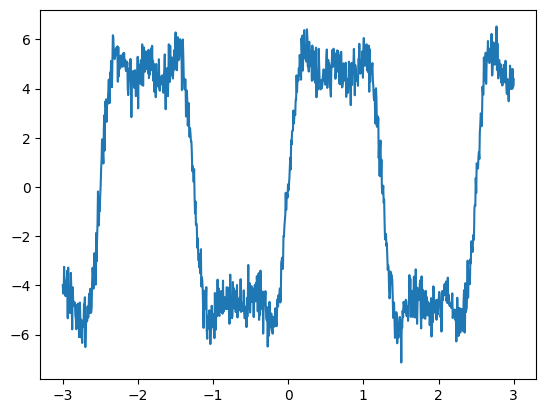

In [21]:
plt.plot(x, y)

In [22]:
sample_time = np.mean(x[1:] - x[0:-1])
s = np.std(x[0:-1] - x[1:])
(sample_time, s)

(0.006006006006006006, 2.853423677488955e-16)

We can clearly see that we have some composition of waves as our dataset, and we have a uniform sampling. (The standard deviation is just floating point truncation error.) We can perform a fast fourier transform to get an idea about what frequencies are present in our dataset.

In [23]:
f = np.abs(np.fft.fft(y))
max_freq = np.pi / sample_time # maximum angular frequency
                               # (nyquist frequency)

# we need to mirror the FFT since the output numpy gives is
# between 0 and 2 * max_freq, we need to make it between
# -max_freq and +max_freq
f_mirrored = np.concatenate((f[-500:], f[:500]))

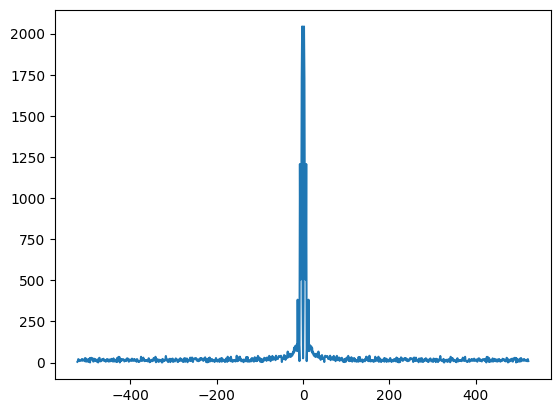

In [24]:
plt.plot(np.arange(-max_freq, max_freq, 2 * max_freq / 1000), f_mirrored)

Looking at the low frequency components (assuming the high-frequency parts are noise): 

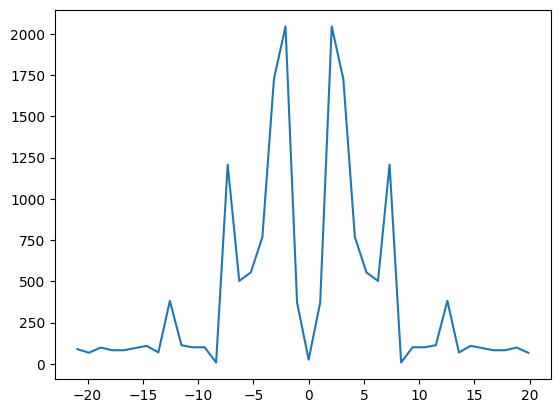

In [25]:
trunc_count = 20

plt.plot(
    np.arange(
        -max_freq / 500 * trunc_count,
        max_freq / 500 * trunc_count,
        2 * max_freq / 1000
    ),
    
    f_mirrored[500-trunc_count:500+trunc_count]
)

So we can see that there are three major frequencies in this plot.

We can assume that the two other frequencies are odd multiples of the least frequency, because:

1. This makes them align nicely with the wave of the least frequency.
2. The graph above suggests so.

So we try to fit the following curve (with 4 parameters) on the given data:
$$y(x) = a_1 \sin(\omega x) + a_2 \sin(3 \omega x) + a_3 \sin(5 \omega x)$$

In [26]:
def sines(t, w, a1, a2, a3):
    return a1 * np.sin(w * t) + \
           a2 * np.sin(3 * w * t) + \
           a3 * np.sin(5 * w * t)

(w, a1, a2, a3), pcov = curve_fit(sines, x, y, p0=[2, 6, 3, 0.75])

print("we estimate the function to be:")
print(f"{a1} sin({w} t) + \n{a2} sin({3 * w} t) + \n{a3} sin({5 * w} t)")

we estimate the function to be:
6.011120042776489 sin(2.5127345558168397 t) + 
2.001458492561091 sin(7.538203667450519 t) + 
0.9809072915150813 sin(12.563672779084198 t)


We can measure the mean squared error to get an idea of how good our fit is:

In [27]:
mse = np.mean((y - sines(x, w, a1, a2, a3)) ** 2)
mse

0.253510060937957

We can also measure the $r^2$ score:

In [28]:
var_y = np.var(y)
r2 = 1 - mse/var_y
r2

0.9877481441373002

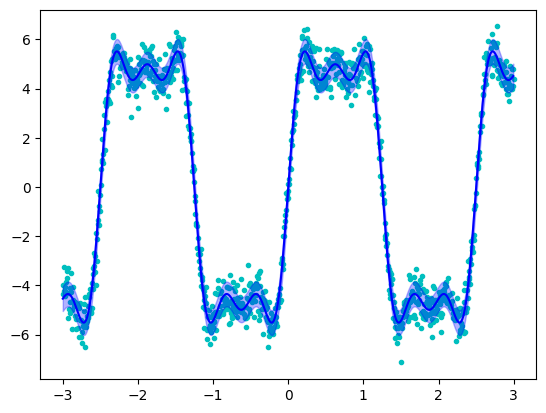

In [29]:
max_x = np.max(x)
min_x = np.min(x)
t = np.arange(min_x, max_x, (max_x - min_x) / len(x))

y_pred = sines(t, w, a1, a2, a3)
plt.plot(x, y, 'c.', t, y_pred, 'blue')
plt.fill_between(t, y_pred - np.sqrt(mse), y_pred + np.sqrt(mse),
                 color='blue', alpha=0.3, zorder=2)

____

# Dataset 3

We first load the dataset:

In [31]:
d = np.loadtxt("dataset3.txt", delimiter=" ")
x = d[0:, 0]
y = d[0:, 1]

print(d.shape)
print(d)

(2999, 2)
[[ 2.00000000e+15 -1.14844543e-09]
 [ 1.99933289e+15 -8.70095067e-10]
 [ 1.99866578e+15  3.19426233e-10]
 ...
 [ 1.33422282e+12 -9.09643878e-10]
 [ 6.67111409e+11  1.41260023e-09]
 [ 1.00000000e+03 -1.65757635e-09]]


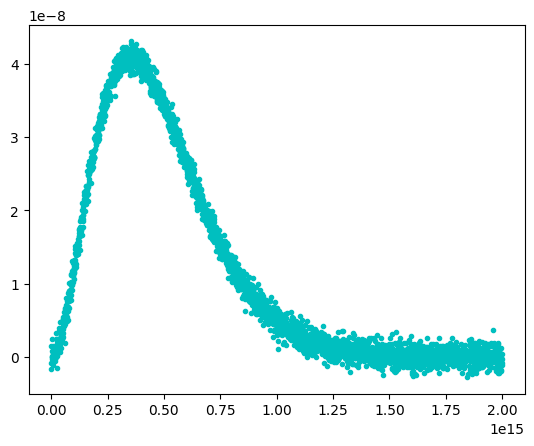

In [32]:
plt.plot(x, y, 'c.')

The equation for black-body radiation is given by:
$$B(\nu, T) = \frac{2 h \nu^3}{c^2} \frac{1}{\exp\left(\frac{h \nu}{k_B T}\right) - 1}$$

We can curve-fit a graph with $h$ and $T$ as unknowns.

In [37]:
c = 3e8
kB = 1.38e-23
def planck(nu, T, h):
    return 2 * (h * nu ** 3) / (c ** 2) / (np.exp(h * nu / (kB * T)) - 1)

(T, h), pcov = curve_fit(planck, x, y, p0=[5000, 6e-34])

h_actual = 6.62607015e-34

print(f"Temperature is {T} K")
print(f"Planck's constant is estimated to be {h} Js")
print(f"(that is an error of {np.abs(1 - (h / h_actual)) * 100:.2}%)")

Temperature is 6011.3615260794995 K
Planck's constant is estimated to be 6.6432297653600676e-34 Js
(that is an error of 0.26%)


We can measure the mean squared error to get an idea of how good our fit is:

In [28]:
mse = np.mean((y - planck(x, T, h)) ** 2)
mse

9.84363342765081e-19

We can also measure the $r^2$ score:

In [29]:
var_y = np.var(y)
r2 = 1 - mse/var_y
r2

0.9950705554018399

Plotting our fit:

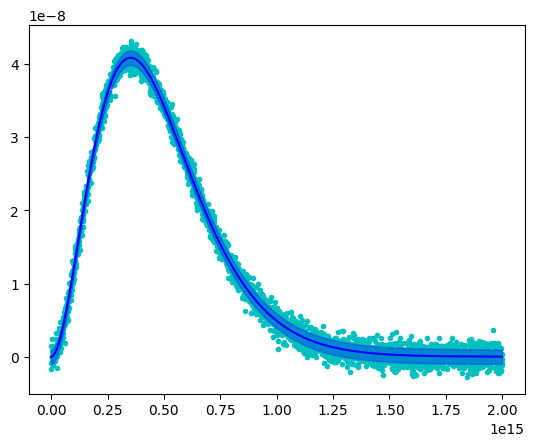

In [31]:
max_x = np.max(x)
min_x = np.min(x)
t = np.arange(min_x, max_x, (max_x - min_x) / len(x))

y_pred = planck(t, T, h)
plt.plot(x, y, 'c.', t, y_pred, 'blue')
plt.fill_between(t, y_pred - np.sqrt(mse), y_pred + np.sqrt(mse),
                 color='blue', alpha=0.3, zorder=2)

____

# Dataset 4

We first load the dataset:

In [3]:
d = np.loadtxt("dataset4.txt", delimiter=" ")
x = d[0:, 0]
y = d[0:, 1]

print(d.shape)
print(d)

(1000, 2)
[[ 0.          3.03964239]
 [ 0.          0.26301448]
 [ 0.          0.15584395]
 ...
 [10.          1.55411664]
 [10.          2.10151596]
 [10.          0.78044386]]


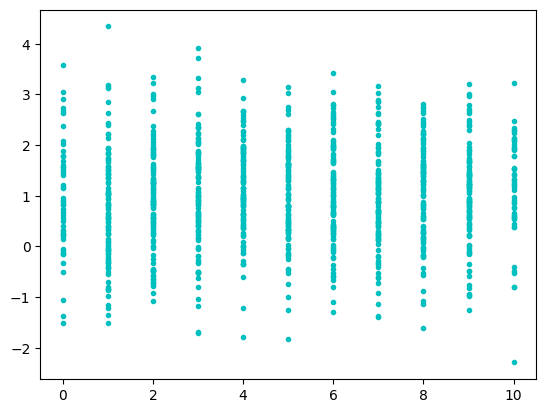

In [9]:
plt.plot(x, y, 'c.')

We can try to create another plot with the mean and error bars:

<ErrorbarContainer object of 3 artists>

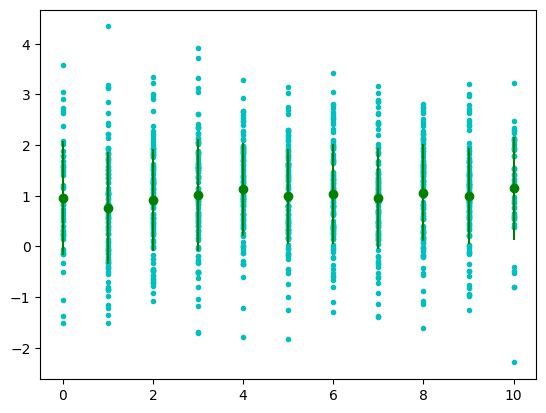

In [10]:
x_unique = np.unique(x)
y_mean = np.zeros(len(x_unique))
y_stdev = np.zeros(len(x_unique))

for i in range(len(x_unique)):
    y_mean[i] = np.mean(y[x == x_unique[i]])
    y_stdev[i] = np.std(y[x == x_unique[i]])

plt.plot(x, y, 'c.')
plt.errorbar(x_unique, y_mean, y_stdev, fmt='go')

It seems like we just have a Gaussian distribution for each value of $x$. We can plot a histogram for each value of $x$ and the net histogram, to be sure:

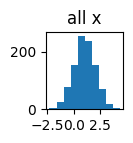

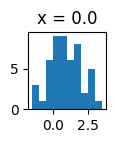

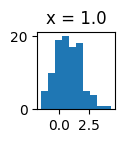

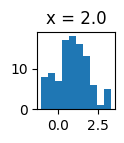

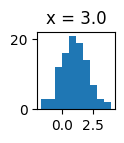

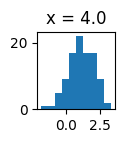

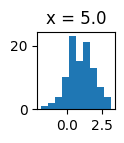

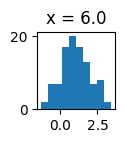

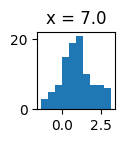

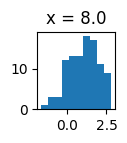

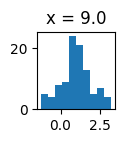

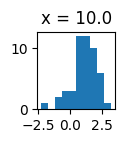

In [11]:
plt.figure(figsize=(1, 1))
plt.hist(y)
plt.title("all x")
plt.show()

for i in range(len(x_unique)):
    plt.figure(figsize=(1, 1))
    plt.hist(y[x == x_unique[i]])
    plt.title(f"x = {x_unique[i]}")
    plt.show()

We can try to get a best-fit line to the data.

In [12]:
M = np.column_stack([x, np.ones(len(x))])
(p1, p2), _, _, _ = np.linalg.lstsq(M, y, rcond=None)

print("we estimate the line to be:")
print(f"{p1} x + {p2}")

we estimate the line to be:
0.01966205154308011 x + 0.8929102782843794


In [13]:
mse = np.mean((y - (p1 * x + p2)) ** 2)
mse

1.018931655732031

We can also measure the $r^2$ score:

In [14]:
var_y = np.var(y)
r2 = 1 - mse/var_y
r2

0.0032146461807900373

We can see that we have a very poor fit for the data. This is because the data is mostly Gaussian noise around a mean.

In fact, it is probably more reasonable to just take the mean of the data and fit a straight line $Y = \bar y$ for the data.

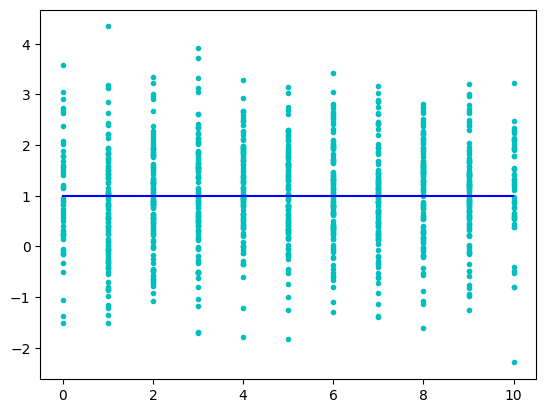

In [19]:
max_x = np.max(x)
min_x = np.min(x)
t = np.arange(min_x, max_x, (max_x - min_x) / len(x))

y_pred = np.mean(y) * np.ones(len(x))
plt.plot(x, y, 'c.', t, y_pred, 'blue')

The mean value obtained is:

In [16]:
np.mean(y)

0.9912205359997815